In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob
from skimage.io import imread
from skimage.draw import polygon_perimeter, polygon
from skimage.morphology import label, medial_axis, skeletonize
from scipy.ndimage.measurements import center_of_mass
from skimage.draw import bezier_curve
from scipy.ndimage.morphology import binary_fill_holes
from skimage.transform import warp, SimilarityTransform
from skimage.graph import route_through_array

In [2]:
img1 = 255 - imread('../images/trimmed_queries_divorce/divorce/G/0_extraction_doc_12_line_23_char_46_original_trim.png', as_grey=True) 
img2 = 255 - imread('../images/trimmed_queries_divorce/queries/G/extraction_doc_13_line_7_char_17_original_trim.png', as_grey=True)
img3 = 255 - imread('../images/trimmed_queries_divorce/divorce/G/1_extraction_doc_5_line_35_char_49_original_trim.png', as_grey=True)

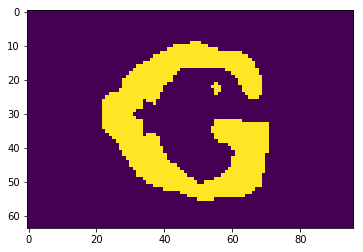

In [33]:
def intersection(ima, imb):
    img = ima.copy()
    img[np.where(ima != imb)] = 0
    return img

def union(ima, imb):
    img = ima.copy()
    img[np.where(imb > 0)] = 255
    return img

# returns the components of ima that are not in imb
# (i.e., deletes imb from ima)
def difference(ima, imb):
    img = ima.copy()
    img[np.where(imb > 0)] = 0
    return img

def create_rectangle(center, height, width, angle, filled = True, shape = (64, 96)):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    corners = np.array([[height/2.0, -1*height/2.0, -1*height/2.0, height/2.0],
                       [width/2.0, width/2.0, -1*width/2.0, -1*width/2.0]])
    corners =  np.transpose(np.matmul(rot_mat, corners) + np.array([[center[0]], [center[1]]])).astype(np.int32)
    
    rect = np.zeros((64, 96), dtype=np.uint8)
    if filled:
        rr, cc = polygon(corners[:,0],
                                   corners[:,1], shape=rect.shape)
    else:
        rr, cc = polygon_perimeter(corners[:,0],
                                   corners[:,1], shape=rect.shape, clip=True)
    rect[rr, cc] = 255
    return rect

def closest_point(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return nodes[np.argmin(dist_2),:].tolist()

def choose_endpts(skeleton, distance):
    skel_pts = np.where(skeleton > 0)
    
    possible_pts = []
    for attempt in range(1000):
        rand_index = np.random.choice(range(len(skel_pts[0])), 1)
        end1 = [skel_pts[0][rand_index][0], skel_pts[1][rand_index][0]]
    
        costs = 255 - skeleton + 1
        for i in range(len(skel_pts[0])):
            pt = [skel_pts[0][i], skel_pts[1][i]]
            _, dist = route_through_array(costs, end1, pt, geometric=False)
            if dist == distance:
                possible_pts = possible_pts + [pt]
        if len(possible_pts) > 0:
            break
    end2 = possible_pts[np.random.choice(range(len(possible_pts)), 1)[0]]
    
    return end1, end2

def perpendicular_angle(end1, end2):
    angle = np.arctan2((np.array(end1) - np.array(end2))[0], (np.array(end1) - np.array(end2))[1])
    return [angle + np.pi/2.0, angle - np.pi/2.0]

def random_endpts_angle(end1, end2):
    angle = np.random.choice(perpendicular_angle(end1, end2), 1)
    return angle[0]

def shift_midpoint(end1, end2, angle, dist_shift):
    init_mid = (np.array(end1) + np.array(end2))/2.0
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-1*np.sin(angle), np.cos(angle)]])
    return np.matmul(rot_mat, np.array([[0], [dist_shift]])) + np.array([[init_mid[0]], [init_mid[1]]])

def bend_skel_with_endpts(skel, end1, end2, dist_shift):
    angle = random_endpts_angle(end1, end2)
    mid = shift_midpoint(end1, end2, angle, dist_shift).astype(np.uint8)
    
    # delete the points from the path
    path, _ = route_through_array(255 - skel, end1, end2)
    skelnew = skel.copy()
    for pt in path:
        skelnew[pt] = 0
    
    rr, cc = bezier_curve(end1[0], end1[1], mid[0][0], mid[1][0],
                        end2[0], end2[1], 2)
    skelnew[rr, cc] = 255
    
    return skelnew

def bend_skel(skel, distance, dist_shift):
    end1, end2 = choose_endpts(skel, distance)
    return bend_skel_with_endpts(skel, end1, end2, dist_shift)

def remove_path(image, orig_skel, new_skel):
    imnew = image.copy()
    path = np.column_stack(np.where(difference(orig_skel, new_skel) > 0)).tolist()
    
    skel_pts = np.column_stack(np.where(orig_skel > 0)).tolist()
    for pt in np.column_stack(np.where(image > 0)).tolist():
        if closest_point(pt, skel_pts) in path:
            imnew[pt[0], pt[1]] = 0
    return imnew

def add_bend(image, orig_skel, bent_skel):
    imnew = remove_path(image, orig_skel, bent_skel)
    new_section = np.column_stack(np.where(difference(bent_skel, orig_skel) > 0)).tolist()
    old_section = np.column_stack(np.where(difference(orig_skel, bent_skel) > 0)).tolist()
    
    _, dist = medial_axis(image, return_distance=True)
    
    for pt in new_section:
        old_pt = closest_point(pt, old_section)
        size = int(dist[old_pt[0], old_pt[1]]) + 1
        imnew = imnew + create_rectangle(pt, size, size, 0)
    
    imnew[np.where(imnew > 0)] = 255
    
    return imnew

def bend_image(image, distance = 13, dist_shift = 9):
    skel = skeletonize(image/255.)*255.
    bent_skel = bend_skel(skel, distance, dist_shift)
    imnew = add_bend(image, skel, bent_skel)
    return imnew
    

imnew = bend_image(img1)
plt.imshow(imnew)
plt.show()

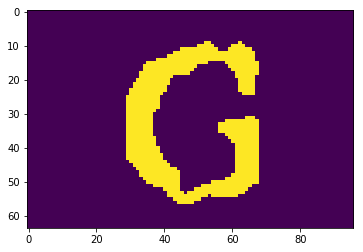

In [46]:
g_files = glob.glob('../images/trimmed_queries_divorce/divorce/G/*.png')
g_array = np.ndarray(shape=(len(g_files), 64, 96))
for ind, f in enumerate(g_files):
    g_array[ind,:,:] = 255 - imread(f, as_grey=True)
    
img = g_array[20,:,:]

imnew = bend_image(img)
plt.imshow(imnew)
plt.show()